In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
import pandas as pd
from pipeline_setup import *
import time

In [2]:
# Set file locations
advanced_settings_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTanjc08kc5vIN-icUMzMEGA9bJuDesLX8V_u2Ab6zSC4MOhLZ8Jrr18DL9o4ofKIrSq6FsJXhPWu3F/pub?gid=0&single=true&output=csv"

# Read in emissions from other sectors
sector_emissions_dict = set_sector_emissions_dict()
# Read in the advanced settings from the google sheet
params = read_advanced_settings(advanced_settings_url)
# Set the datablock
datablock_init = datablock_setup()

# Set the scenario parameters
set_baseline_scenario(params);

In [3]:
# Do a test calculation
starttime = time.time()
SSR_result, emissions_result = SSR_emissions(datablock_init, params, sector_emissions_dict)
lasttime = time.time()
duration = lasttime - starttime

print(f"SSR = {SSR_result:.8f}; GHG = {emissions_result:.8f}")
# This is my checksum for debugging: 
# SSR = 0.67366432; GHG = 94.22954995

SSR = 0.67366432; GHG = 94.22954995


In [23]:
# Reproduce the 2d plot JP made
n1 = 9
n2 = 10
name1 = "horticulture"
x1_min = 0
x1_max = 200
name2 = "foresting_pasture"
x2_min = 15
x2_max = 50

# Now make the arrays
x1_vals = np.linspace(x1_min, x1_max, n1)
x2_vals = np.linspace(x2_min, x2_max, n2)
SSR_results = np.empty((n1,n2))
emissions_results = np.empty((n1,n2))
x1_mat = np.empty((n1,n2))
x2_mat = np.empty((n1,n2))

starttime = time.time()
for i1, x1 in enumerate(x1_vals):
    params[name1] = x1

    for i2, x2 in enumerate(x2_vals):
        params[name2] = x2

        SSR_results[i1, i2], emissions_results[i1, i2] = SSR_emissions(datablock_init, params, sector_emissions_dict)
        x1_mat[i1, i2] = x1
        x2_mat[i1, i2] = x2

    lasttime = time.time()
    duration = lasttime - starttime
    eta = (duration / (i1+1) * (n1-i1-1))/60
    print(f"Done i1 = {i1:2} of {n1:2}; eta = {eta:.2f} minutes")

totaltime = time.time()
time_per_function_call = (totaltime - starttime) / (n1 * n2)
print(f"time_per_function_call = {time_per_function_call:.2f} seconds")

Done i1 =  0 of  9; eta = 2.30 minutes
Done i1 =  1 of  9; eta = 2.01 minutes
Done i1 =  2 of  9; eta = 1.72 minutes
Done i1 =  3 of  9; eta = 1.43 minutes
Done i1 =  4 of  9; eta = 1.14 minutes
Done i1 =  5 of  9; eta = 0.85 minutes
Done i1 =  6 of  9; eta = 0.59 minutes
Done i1 =  7 of  9; eta = 0.29 minutes
Done i1 =  8 of  9; eta = 0.00 minutes
time_per_function_call = 1.74 seconds


In [24]:
# Interpolate the outputs
ni = 100 # Factor by which to interpolate
SSR_resultsi = zoom(SSR_results, zoom=ni, order=3)  # cubic interpolation
emissions_resultsi = zoom(emissions_results, zoom=ni, order=3)  # cubic interpolation
x1_mati = zoom(x1_mat, zoom=ni, order=3)  # cubic interpolation
x2_mati = zoom(x2_mat, zoom=ni, order=3)  # cubic interpolation

In [25]:
# cut all values where the SSR went below today's value
SSR_threshold = 0.7202
emissions_fill_value = 94.23
#SSR_masked_resultsi = np.ma.masked_less(SSR_resultsi, SSR_threshold)

In [26]:
indices = np.where(SSR_resultsi < SSR_threshold)
emissions_masked_resultsi = emissions_resultsi
emissions_masked_resultsi[indices] = emissions_fill_value
SSR_masked_resultsi = SSR_resultsi
SSR_masked_resultsi[indices] = 1

Text(0.5, 0, 'foresting_pasture')

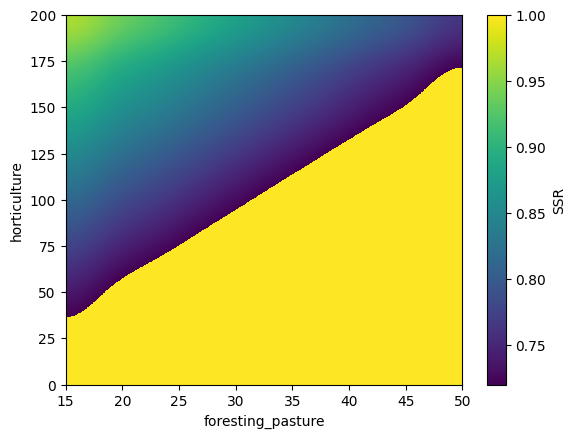

In [27]:
plt.imshow(SSR_masked_resultsi, cmap='viridis', interpolation='nearest', extent=[x2_min, x2_max, x1_min, x1_max], origin='lower', aspect='auto')
plt.colorbar(label='SSR')
plt.ylabel(name1)
plt.xlabel(name2)

Text(0.5, 0, 'foresting_pasture')

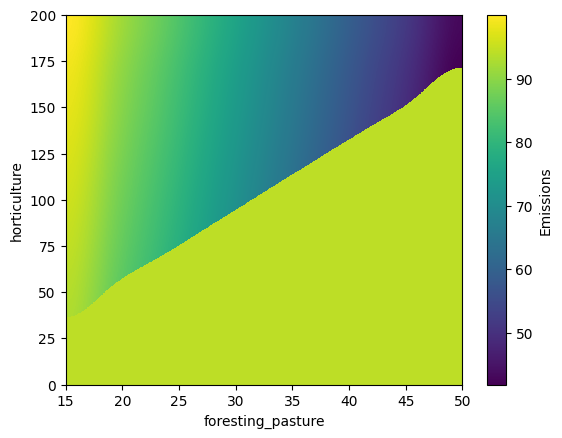

In [28]:
plt.imshow(emissions_resultsi, cmap='viridis', interpolation='nearest', extent=[x2_min, x2_max, x1_min, x1_max], origin='lower', aspect='auto')
plt.colorbar(label='Emissions')
plt.ylabel(name1)
plt.xlabel(name2)

In [29]:
indices = np.where(SSR_masked_resultsi < SSR_threshold)
emissions_masked_resultsi = emissions_resultsi
emissions_masked_resultsi[indices] = emissions_fill_value

Text(0.5, 0, 'foresting_pasture')

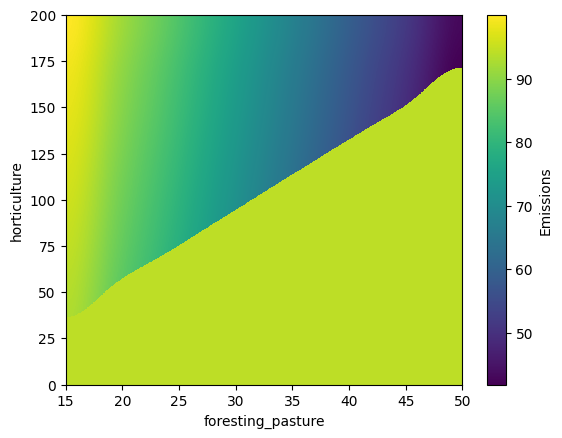

In [30]:
plt.imshow(emissions_masked_resultsi, cmap='viridis', interpolation='nearest', extent=[x2_min, x2_max, x1_min, x1_max], origin='lower', aspect='auto')
plt.colorbar(label='Emissions')
plt.ylabel(name1)
plt.xlabel(name2)

In [31]:
# Find the minimum emissions where SSR is greater than today
indices = np.where(emissions_masked_resultsi == np.min(emissions_masked_resultsi))
print(f"{name1} = {x1_mati[indices]}; {name2} = {x2_mati[indices]}; emissions = {emissions_resultsi[indices]}; SSR = {SSR_resultsi[indices]}")

horticulture = [171.05992885]; foresting_pasture = [49.99513594]; emissions = [41.84794324]; SSR = [0.72020509]


In [ ]:
# Can I get the same results using the minimiser function???
calculator_tol = 1e-3
